In [1]:
# 필요 라이브러리 로드
from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3,os
import pandas as pd
import platform
from autogluon.tabular import TabularDataset, TabularPredictor
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
if platform.system() == 'Windows':
# 윈도우인 경우 맑은 고딕 폰트 이용
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf"
                                           ).get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

#그래프에서 마이너스 기호가 표시되게 하는 설정입니다.
plt.rcParams['axes.unicode_minus'] == False

c:\Users\ban05\anaconda3\envs\machine_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

In [4]:
path = '../processing_data/시간당_전국_평균날씨.csv'
# blackout_df = pd.read_excel(path1)
df_weather = pd.read_csv(path, encoding='cp949')
# df_power.drop(columns = 'Unnamed: 0', inplace =True)

In [ ]:
path = '../data/한국전력거래소_지역별 시간별 태양광 발전량_20211231.csv'
# blackout_df = pd.read_excel(path1)
df_power = pd.read_csv(path, encoding='cp949')
# df_power.drop(columns = 'Unnamed: 0', inplace =True)

In [4]:
df_power.head(2)

,거래일자,거래시간,지역,발전량
0,2018-01-01,1,강원도,13.68
1,2018-01-01,2,강원도,0.00


In [5]:
df_weather.head(2)

,Unnamed: 0,year,month,day,hour,기온(°C),풍속(m/s),습도(%)
0,0,2011,1,1,8,-8.084615,2.711111,71.076923
1,1,2011,1,1,9,-6.949451,3.018889,68.164835


In [6]:
df_weather.drop(columns='Unnamed: 0', inplace=True)

In [7]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44198 entries, 0 to 44197
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   year     44198 non-null  int64  
 1   month    44198 non-null  int64  
 2   day      44198 non-null  int64  
 3   hour     44198 non-null  int64  
 4   기온(°C)   44198 non-null  float64
 5   풍속(m/s)  44198 non-null  float64
 6   습도(%)    44198 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 2.4 MB


In [8]:
df_weather['일시'] =  df_weather['year'].astype(str) + '-' + df_weather['month'].astype(str).str.zfill(2) + '-' + df_weather['day'].astype(str).str.zfill(2) +'-' + df_weather['hour'].astype(str).str.zfill(2)

In [9]:
df_weather

,year,month,day,hour,기온(°C),풍속(m/s),습도(%),일시
0,2011,1,1,8,-8.084615,2.711111,71.076923,2011-01-01-08
1,2011,1,1,9,-6.949451,3.018889,68.164835,2011-01-01-09
2,2011,1,1,10,-5.206593,3.298889,62.373626,2011-01-01-10
3,2011,1,1,11,-3.467033,3.546667,56.021978,2011-01-01-11
4,2011,1,1,12,-2.163736,3.793333,52.824176,2011-01-01-12
...,...,...,...,...,...,...,...,...
44193,2021,12,31,14,-0.069474,4.278947,35.442105,2021-12-31-14
44194,2021,12,31,15,0.003158,4.242105,35.094737,2021-12-31-15
44195,2021,12,31,16,-0.333684,4.106316,34.778947,2021-12-31-16
44196,2021,12,31,17,-1.307368,3.383158,36.505263,2021-12-31-17


In [10]:
# convert column B to timedelta object
df_weather['일시'] = pd.to_datetime(df_weather['일시'])


In [11]:
df_weather.drop(columns=['year','month','day','hour'], inplace=True)
df_weather

,기온(°C),풍속(m/s),습도(%),일시
0,-8.084615,2.711111,71.076923,2011-01-01 08:00:00
1,-6.949451,3.018889,68.164835,2011-01-01 09:00:00
2,-5.206593,3.298889,62.373626,2011-01-01 10:00:00
3,-3.467033,3.546667,56.021978,2011-01-01 11:00:00
4,-2.163736,3.793333,52.824176,2011-01-01 12:00:00
...,...,...,...,...
44193,-0.069474,4.278947,35.442105,2021-12-31 14:00:00
44194,0.003158,4.242105,35.094737,2021-12-31 15:00:00
44195,-0.333684,4.106316,34.778947,2021-12-31 16:00:00
44196,-1.307368,3.383158,36.505263,2021-12-31 17:00:00


In [12]:
# convert column B to timedelta object
df_power['거래시간'] = pd.to_timedelta(df_power['거래시간'], unit='H')
df_power['거래시간'] 
# add column B to column A
df_power['일시'] = pd.to_datetime(df_power['거래일자']) + df_power['거래시간']
df_power['일시']
# replace time in column A with updated time

# drop column B if no longer needed
df_power.drop(['거래일자', '거래시간'], axis=1, inplace=True)



In [13]:
df_power.set_index('일시',inplace=True)

df_power = df_power.between_time('8:00:00', '18:00:00')
df_power.reset_index(col_fill= '일시')

,일시,지역,발전량
0,2018-01-01 08:00:00,강원도,113.859
1,2018-01-01 09:00:00,강원도,8704.912
2,2018-01-01 10:00:00,강원도,41926.638
3,2018-01-01 11:00:00,강원도,67930.358
4,2018-01-01 12:00:00,강원도,81280.313
...,...,...,...
273202,2021-12-31 14:00:00,충청북도,113775.537
273203,2021-12-31 15:00:00,충청북도,101522.028
273204,2021-12-31 16:00:00,충청북도,70747.386
273205,2021-12-31 17:00:00,충청북도,23120.171


In [14]:
df_power.reset_index(col_fill= '일시',inplace=True)

In [15]:
df_power.columns

Index(['일시', '지역', '발전량 '], dtype='object')

In [16]:
df_weather.columns

Index(['기온(°C)', '풍속(m/s)', '습도(%)', '일시'], dtype='object')

In [17]:
print(df_weather.head(1))
print(df_weather.tail(1))

     기온(°C)   풍속(m/s)      습도(%)                  일시
0 -8.084615  2.711111  71.076923 2011-01-01 08:00:00
         기온(°C)   풍속(m/s)      습도(%)                  일시
44197 -2.262105  2.872632  38.947368 2021-12-31 18:00:00


In [18]:
df_weather

,기온(°C),풍속(m/s),습도(%),일시
0,-8.084615,2.711111,71.076923,2011-01-01 08:00:00
1,-6.949451,3.018889,68.164835,2011-01-01 09:00:00
2,-5.206593,3.298889,62.373626,2011-01-01 10:00:00
3,-3.467033,3.546667,56.021978,2011-01-01 11:00:00
4,-2.163736,3.793333,52.824176,2011-01-01 12:00:00
...,...,...,...,...
44193,-0.069474,4.278947,35.442105,2021-12-31 14:00:00
44194,0.003158,4.242105,35.094737,2021-12-31 15:00:00
44195,-0.333684,4.106316,34.778947,2021-12-31 16:00:00
44196,-1.307368,3.383158,36.505263,2021-12-31 17:00:00


In [19]:
df_power = df_power.groupby(['일시'], as_index=False)['발전량 '].sum()

In [20]:
df_power.sort_values(by = '일시', inplace=True)
df_power

,일시,발전량
0,2018-01-01 08:00:00,2291.804
1,2018-01-01 09:00:00,143013.314
2,2018-01-01 10:00:00,561218.534
3,2018-01-01 11:00:00,936323.050
4,2018-01-01 12:00:00,1147049.328
...,...,...
16066,2021-12-31 14:00:00,2024235.521
16067,2021-12-31 15:00:00,1812785.242
16068,2021-12-31 16:00:00,1225458.456
16069,2021-12-31 17:00:00,478778.417


In [21]:
df_weather

,기온(°C),풍속(m/s),습도(%),일시
0,-8.084615,2.711111,71.076923,2011-01-01 08:00:00
1,-6.949451,3.018889,68.164835,2011-01-01 09:00:00
2,-5.206593,3.298889,62.373626,2011-01-01 10:00:00
3,-3.467033,3.546667,56.021978,2011-01-01 11:00:00
4,-2.163736,3.793333,52.824176,2011-01-01 12:00:00
...,...,...,...,...
44193,-0.069474,4.278947,35.442105,2021-12-31 14:00:00
44194,0.003158,4.242105,35.094737,2021-12-31 15:00:00
44195,-0.333684,4.106316,34.778947,2021-12-31 16:00:00
44196,-1.307368,3.383158,36.505263,2021-12-31 17:00:00


In [22]:
merge_outer = pd.merge(df_power,df_weather, how='outer',on='일시')
merge_outer.sort_values(by = '일시', inplace=True)

In [23]:
merge_outer.fillna(0, inplace=True)
merge_outer.head(10)

,일시,발전량,기온(°C),풍속(m/s),습도(%)
16071,2011-01-01 08:00:00,0.0,-8.084615,2.711111,71.076923
16072,2011-01-01 09:00:00,0.0,-6.949451,3.018889,68.164835
16073,2011-01-01 10:00:00,0.0,-5.206593,3.298889,62.373626
16074,2011-01-01 11:00:00,0.0,-3.467033,3.546667,56.021978
16075,2011-01-01 12:00:00,0.0,-2.163736,3.793333,52.824176
16076,2011-01-01 13:00:00,0.0,-1.009890,3.697778,50.428571
16077,2011-01-01 14:00:00,0.0,-0.275824,3.886667,50.120879
16078,2011-01-01 15:00:00,0.0,0.068132,3.642222,50.186813
16079,2011-01-01 16:00:00,0.0,-0.046154,3.514444,50.725275
16080,2011-01-01 17:00:00,0.0,-0.891209,2.996667,53.989011


In [24]:
# 태양광 에너지 생산량이 2018-01-01~2021-12-31있기에 이 데이터도 맞춰서 슬라이싱
start_date = pd.to_datetime('2018-01-01 00:00')
end_date = pd.to_datetime('2021-12-31 18:00')
filtered_df = merge_outer[(merge_outer['일시'] >= start_date) & (merge_outer['일시'] <= end_date)]


In [25]:
filtered_df

,일시,발전량,기온(°C),풍속(m/s),습도(%)
0,2018-01-01 08:00:00,2291.804,-4.125263,1.271579,66.000000
1,2018-01-01 09:00:00,143013.314,-2.233684,1.448421,59.936842
2,2018-01-01 10:00:00,561218.534,0.192632,1.996842,49.073684
3,2018-01-01 11:00:00,936323.050,2.109474,2.484211,38.894737
4,2018-01-01 12:00:00,1147049.328,3.256842,2.934737,32.368421
...,...,...,...,...,...
16066,2021-12-31 14:00:00,2024235.521,-0.069474,4.278947,35.442105
16067,2021-12-31 15:00:00,1812785.242,0.003158,4.242105,35.094737
16068,2021-12-31 16:00:00,1225458.456,-0.333684,4.106316,34.778947
16069,2021-12-31 17:00:00,478778.417,-1.307368,3.383158,36.505263


In [26]:
# 윤달 제거 
start_date = pd.to_datetime('2020-02-29 00:00')
end_date = pd.to_datetime('2020-02-29 23:00')
filtered_df = filtered_df[(filtered_df['일시'] < start_date) | (filtered_df['일시'] > end_date)]


In [27]:
# 2018 1월 1일 0시부터 ~ 2020년 12월 31일 24시까지
train_y_s  = filtered_df[['발전량 ', '일시']].iloc[:-8760]
filtered_df.fillna(0, inplace=True)
train_y  = filtered_df['발전량 '].iloc[:-8760]
# print(train_y_s.head(1),train_y_s.tail(1))
train_y_s

C:\Users\ban05\AppData\Local\Temp\ipykernel_16980\840817337.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.fillna(0, inplace=True)


,발전량,일시
0,2291.804,2018-01-01 08:00:00
1,143013.314,2018-01-01 09:00:00
2,561218.534,2018-01-01 10:00:00
3,936323.050,2018-01-01 11:00:00
4,1147049.328,2018-01-01 12:00:00
...,...,...
7295,1112787.428,2019-10-26 10:00:00
7296,1212002.103,2019-10-26 11:00:00
7297,1430213.094,2019-10-26 12:00:00
7298,1526653.463,2019-10-26 13:00:00


In [28]:
# 2021년 1월 1일 0시부터 ~ 2021년 12월 31일 24시까지
test_y_s = filtered_df[['발전량 ', '일시']].iloc[-8737:]
test_y = filtered_df['발전량 '].iloc[-8737:]
print(test_y_s.head(1),test_y_s.tail(1))

            발전량                   일시
7323  902178.159 2019-10-28 16:00:00              발전량                   일시
16070  613917.184 2021-12-31 18:00:00


In [29]:
# 2012년 6월 1일 0시부터 ~ 2019년 12월 31일 24시까지
train_x = filtered_df.iloc[8760:]
train_x
# print(train_x['일시'].head(1),train_x['일시'].tail(1))

,일시,발전량,기온(°C),풍속(m/s),습도(%)
8771,2020-03-08 12:00:00,2016674.433,12.363158,1.987368,51.073684
8772,2020-03-08 13:00:00,2200691.650,13.818947,2.350526,44.884211
8773,2020-03-08 14:00:00,2371064.686,14.743158,2.301053,42.094737
8774,2020-03-08 15:00:00,2365097.986,15.129474,2.289474,41.021053
8775,2020-03-08 16:00:00,1983478.755,14.973684,2.408421,42.200000
...,...,...,...,...,...
16066,2021-12-31 14:00:00,2024235.521,-0.069474,4.278947,35.442105
16067,2021-12-31 15:00:00,1812785.242,0.003158,4.242105,35.094737
16068,2021-12-31 16:00:00,1225458.456,-0.333684,4.106316,34.778947
16069,2021-12-31 17:00:00,478778.417,-1.307368,3.383158,36.505263


In [30]:
# 2021년 1월 1일 0시부터 ~ 2021년 12월 31일 24시까지
test_x = filtered_df.iloc[-8760:]
test_x
# print(test_x['일시'].head(1),test_x['일시'].tail(1))

,일시,발전량,기온(°C),풍속(m/s),습도(%)
7300,2019-10-26 15:00:00,1190632.345,15.902105,3.535106,47.021053
7301,2019-10-26 16:00:00,769875.027,15.285263,3.256383,49.610526
7302,2019-10-26 17:00:00,365308.957,14.106316,2.610638,53.842105
7303,2019-10-26 18:00:00,228592.778,12.696842,2.086170,60.652632
7304,2019-10-27 08:00:00,179442.488,7.784211,1.453191,79.210526
...,...,...,...,...,...
16066,2021-12-31 14:00:00,2024235.521,-0.069474,4.278947,35.442105
16067,2021-12-31 15:00:00,1812785.242,0.003158,4.242105,35.094737
16068,2021-12-31 16:00:00,1225458.456,-0.333684,4.106316,34.778947
16069,2021-12-31 17:00:00,478778.417,-1.307368,3.383158,36.505263


y 값에 일시에 칼럼을 넣었을 때 사용하는 것 

In [31]:
train_x.columns

Index(['일시', '발전량 ', '기온(°C)', '풍속(m/s)', '습도(%)'], dtype='object')

In [32]:
train_x

,일시,발전량,기온(°C),풍속(m/s),습도(%)
8771,2020-03-08 12:00:00,2016674.433,12.363158,1.987368,51.073684
8772,2020-03-08 13:00:00,2200691.650,13.818947,2.350526,44.884211
8773,2020-03-08 14:00:00,2371064.686,14.743158,2.301053,42.094737
8774,2020-03-08 15:00:00,2365097.986,15.129474,2.289474,41.021053
8775,2020-03-08 16:00:00,1983478.755,14.973684,2.408421,42.200000
...,...,...,...,...,...
16066,2021-12-31 14:00:00,2024235.521,-0.069474,4.278947,35.442105
16067,2021-12-31 15:00:00,1812785.242,0.003158,4.242105,35.094737
16068,2021-12-31 16:00:00,1225458.456,-0.333684,4.106316,34.778947
16069,2021-12-31 17:00:00,478778.417,-1.307368,3.383158,36.505263


In [33]:
train_x.rename(columns = {'발전량 ':'1년전 발전량'}, inplace=True)
test_x.rename(columns = {'발전량 ':'1년전 발전량'}, inplace=True)

C:\Users\ban05\AppData\Local\Temp\ipykernel_16980\2124706754.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x.rename(columns = {'발전량 ':'1년전 발전량'}, inplace=True)
C:\Users\ban05\AppData\Local\Temp\ipykernel_16980\2124706754.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x.rename(columns = {'발전량 ':'1년전 발전량'}, inplace=True)


In [35]:
train_x.head(2)

,일시,1년전 발전량,기온(°C),풍속(m/s),습도(%)
8771,2020-03-08 12:00:00,2016674.433,12.363158,1.987368,51.073684
8772,2020-03-08 13:00:00,2200691.650,13.818947,2.350526,44.884211


2년치 2018~2019년도까지 날씨 데이터를 사용하여 
수요 데이터를 예측 

In [36]:
train_x.reset_index(inplace=True)
test_x.reset_index(inplace=True)

In [154]:
# train_x.to_csv('train_x.csv', encoding= 'cp949')
# train_y.to_frame().reset_index().to_csv('train_y.csv', encoding= 'cp949')
# test_x.to_csv('test_x.csv', encoding= 'cp949')
# test_y.to_frame().reset_index().to_csv('test_y.csv', encoding= 'cp949')

In [37]:
train = pd.concat([train_x, train_y.to_frame().reset_index()], axis=1)
test = pd.concat([test_x, test_y.to_frame().reset_index()], axis=1)
test = test.drop(columns = ['index'])
train = train.drop(columns = ['index'])
# test.tail(20)

In [159]:
# test.to_csv('test.csv', encoding= 'cp949')
# train.to_csv('train.csv', encoding= 'cp949')

In [38]:
test.columns

Index(['일시', '1년전 발전량', '기온(°C)', '풍속(m/s)', '습도(%)', '발전량 '], dtype='object')

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   일시       8760 non-null   datetime64[ns]
 1   1년전 발전량  8760 non-null   float64       
 2   기온(°C)   8760 non-null   float64       
 3   풍속(m/s)  8760 non-null   float64       
 4   습도(%)    8760 non-null   float64       
 5   발전량      8737 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 410.8 KB


In [40]:
# train.columns
# train.drop(columns = 'index', inplace = True)
train.columns

Index(['일시', '1년전 발전량', '기온(°C)', '풍속(m/s)', '습도(%)', '발전량 '], dtype='object')

In [41]:
train

,일시,1년전 발전량,기온(°C),풍속(m/s),습도(%),발전량
0,2020-03-08 12:00:00,2016674.433,12.363158,1.987368,51.073684,2291.804
1,2020-03-08 13:00:00,2200691.650,13.818947,2.350526,44.884211,143013.314
2,2020-03-08 14:00:00,2371064.686,14.743158,2.301053,42.094737,561218.534
3,2020-03-08 15:00:00,2365097.986,15.129474,2.289474,41.021053,936323.050
4,2020-03-08 16:00:00,1983478.755,14.973684,2.408421,42.200000,1147049.328
...,...,...,...,...,...,...
7295,2021-12-31 14:00:00,2024235.521,-0.069474,4.278947,35.442105,1112787.428
7296,2021-12-31 15:00:00,1812785.242,0.003158,4.242105,35.094737,1212002.103
7297,2021-12-31 16:00:00,1225458.456,-0.333684,4.106316,34.778947,1430213.094
7298,2021-12-31 17:00:00,478778.417,-1.307368,3.383158,36.505263,1526653.463


In [42]:
# hyperparameters = {'NN': {'num_epochs': 5000}, 'GBM': {'num_boost_round': 5000}}
# predictor = TabularPredictor(label='현재수요(MW)', hyperparameters=hyperparameters).fit(train)
predictor = TabularPredictor(label='발전량 ').fit(train)

No path specified. Models will be saved in: "AutogluonModels\ag-20230329_095255\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230329_095255\"
AutoGluon Version:  0.7.0
Python Version:     3.8.16
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Train Data Rows:    7300
Train Data Columns: 5
Label Column: 발전량 
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (2040495.358, 76.531, 786691.35065, 479840.02191)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9257.22 MB
	Train Data (Orig

[1000]	valid_set's rmse: 347918
[2000]	valid_set's rmse: 332971
[3000]	valid_set's rmse: 326249
[4000]	valid_set's rmse: 323100
[5000]	valid_set's rmse: 321427
[6000]	valid_set's rmse: 319817
[7000]	valid_set's rmse: 319670
[8000]	valid_set's rmse: 319253
[9000]	valid_set's rmse: 319102
[10000]	valid_set's rmse: 318934


	-318923.5297	 = Validation score   (-root_mean_squared_error)
	6.55s	 = Training   runtime
	0.17s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 339640
[2000]	valid_set's rmse: 334813


	-334069.1293	 = Validation score   (-root_mean_squared_error)
	1.43s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-335303.8529	 = Validation score   (-root_mean_squared_error)
	1.73s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-323785.1011	 = Validation score   (-root_mean_squared_error)
	100.69s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-331787.4637	 = Validation score   (-root_mean_squared_error)
	0.6s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-375568.4219	 = Validation score   (-root_mean_squared_error)
	7.73s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-337194.487	 = Validation score   (-root_mean_squared_error)
	2.79s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-349841.0216	 = Validation score   (-root_mean_squared_error)
	60.77s	 = Training

[1000]	valid_set's rmse: 334791
[2000]	valid_set's rmse: 333913
[3000]	valid_set's rmse: 333727
[4000]	valid_set's rmse: 333666
[5000]	valid_set's rmse: 333659
[6000]	valid_set's rmse: 333659
[7000]	valid_set's rmse: 333658
[8000]	valid_set's rmse: 333658
[9000]	valid_set's rmse: 333658
[10000]	valid_set's rmse: 333658


	-333657.8998	 = Validation score   (-root_mean_squared_error)
	17.24s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-241564.4931	 = Validation score   (-root_mean_squared_error)
	0.32s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 205.81s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230329_095255\")


In [43]:
test_preds = predictor.predict(test)
# test_preds.sort_index()

In [ ]:
# ld_board = predictor.leaderboard(test, silent=True)
# ld_board

In [44]:
test_date = filtered_df['일시'].iloc[-8737:]

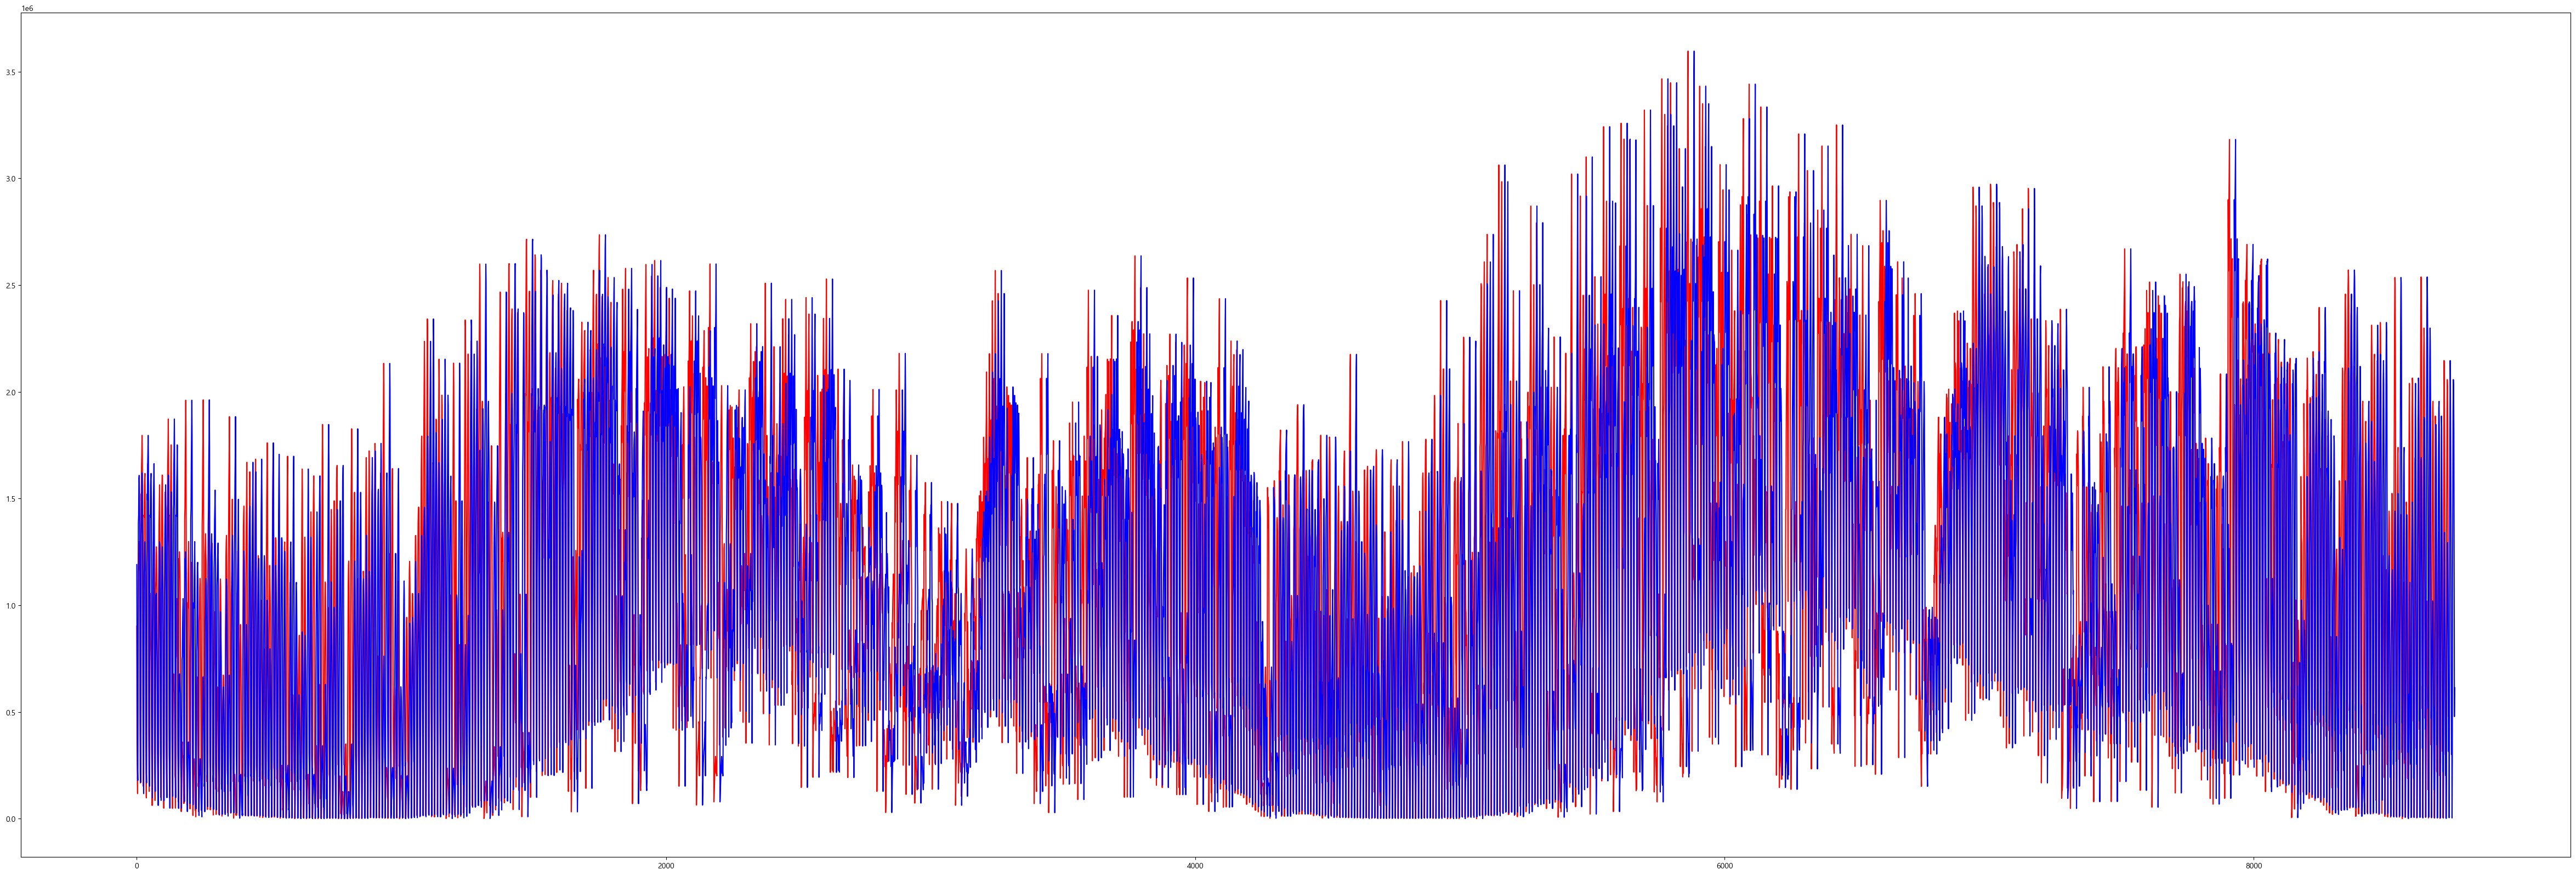

In [46]:
fig, ax = plt.subplots(figsize=(60,20))
ax.plot(test['발전량 '], color='red', label='test_y')
ax.plot(test['1년전 발전량'],color='blue', label='train_y')
plt.show()

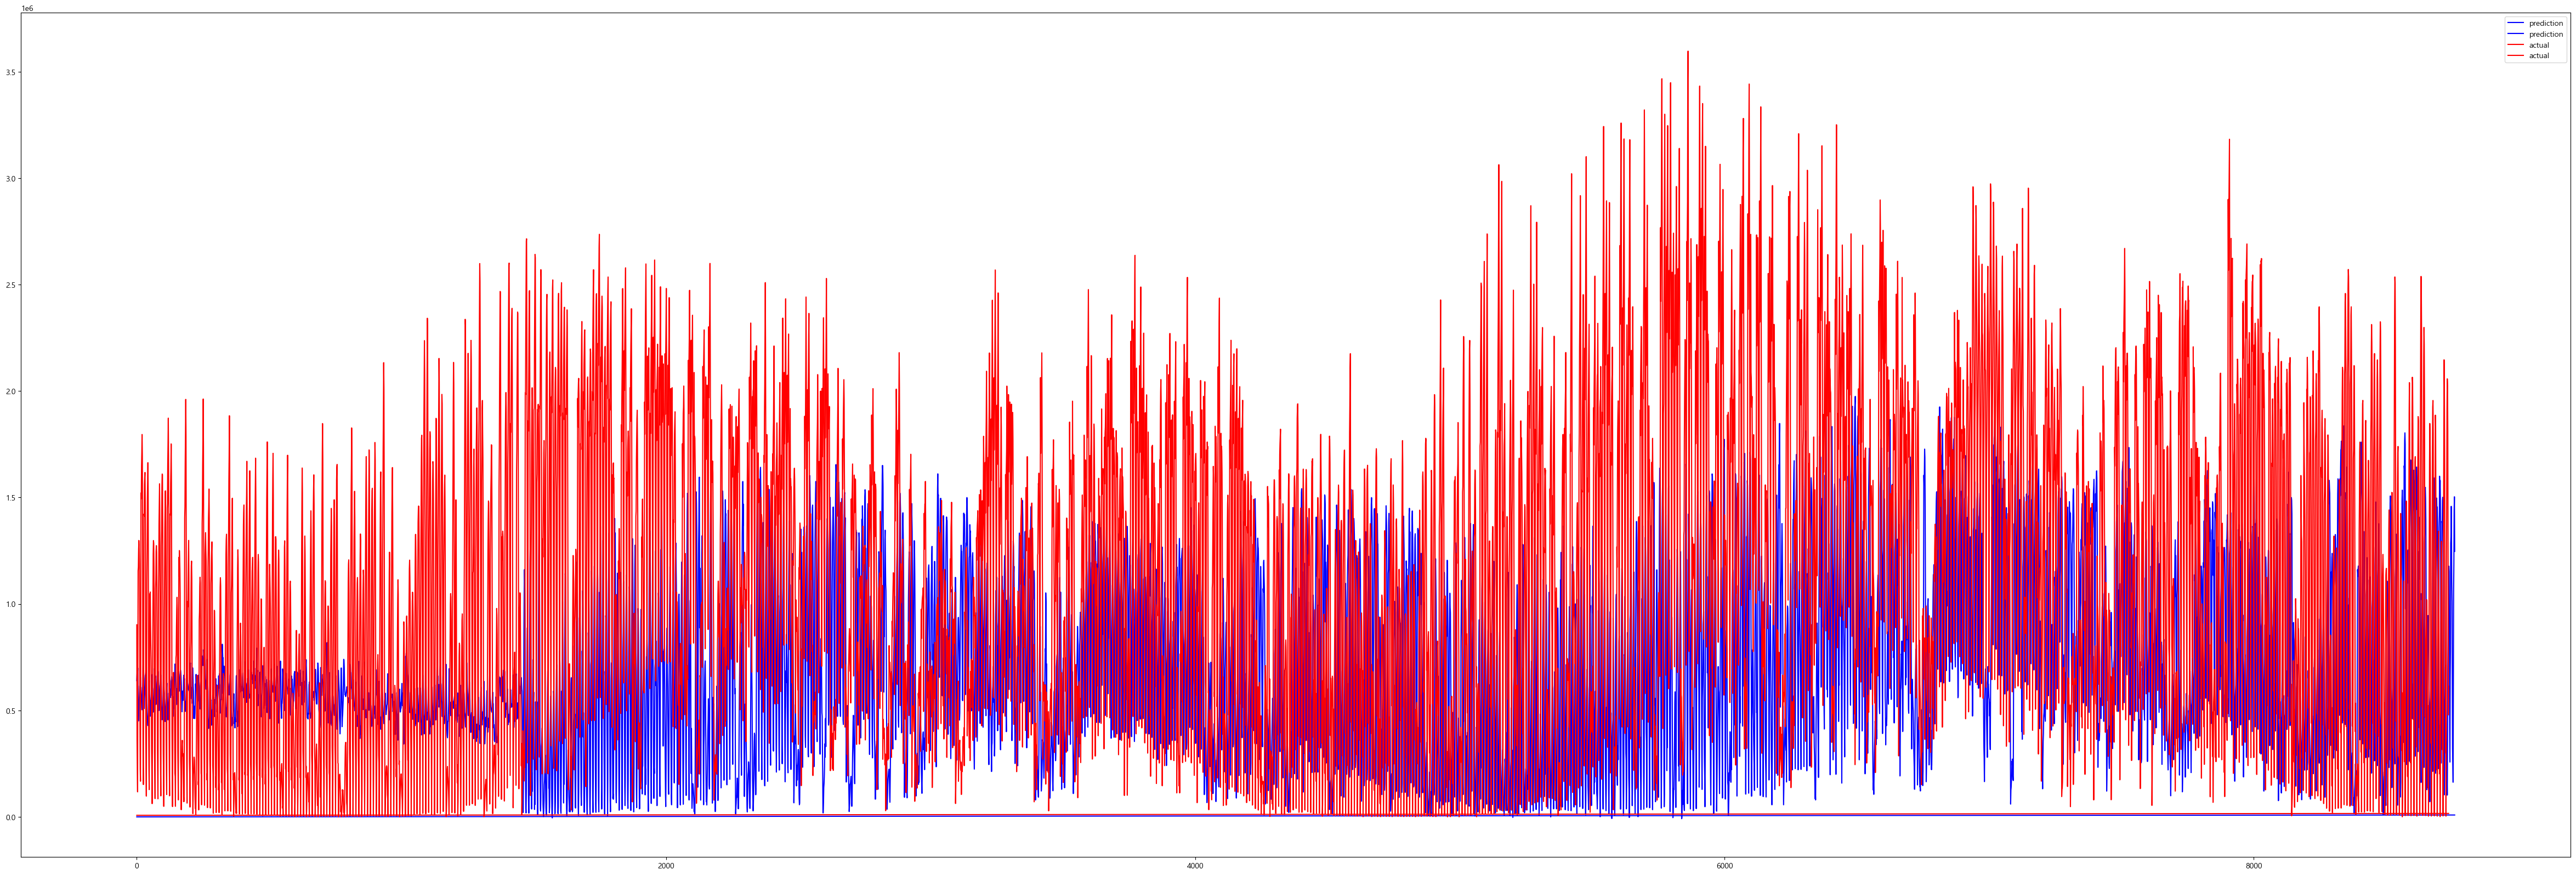

In [47]:
# Create a figure and axes object
fig, ax = plt.subplots(figsize=(60,20))

# Plot the first value as a blue line /Value 1
ax.plot(test_preds.reset_index(), color='blue', label='prediction')

# Plot the second value as a red line /Value 2
ax.plot(test_y.reset_index(), color='red', label='actual')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [ ]:
# Assume predicted values are stored in a pandas series called 'predicted'
# Assume actual values are stored in a pandas data frame column called 'actual'

# Calculate the margin of error (absolute difference between predicted and actual)
margin_of_error = test_preds.reset_index() - test['현재수요(MW)'].reset_index()

# Calculate the mean absolute error (MAE)
mae = margin_of_error.mean()

# Calculate the mean percentage error (MPE)
mpe = (margin_of_error / test['현재수요(MW)']).mean() * 100

# Calculate the mean squared error (MSE)
mse = np.square(margin_of_error).mean()

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

# Print the results
print(f"Margin of error: {margin_of_error}")
print(f"MAE: {mae}")
print(f"MPE: {mpe}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

Margin of error: 0        6541.725000
1        8934.494267
2       10693.940625
3       11721.926562
4       12001.594267
            ...     
8732    -4311.470312
8733    -1364.236983
8734      239.518233
8735     -607.893233
8736     2147.278642
Name: 현재수요(MW), Length: 8737, dtype: float64
MAE: 7487.286130876731
MPE: 13.692165634280187
MSE: 131187171.22617693
RMSE: 11453.696836662692


In [ ]:
margin_of_error.to_csv('pred_WeightedEnsemble_L2_model.csv' , encoding= 'cp949')

In [ ]:
margin_of_error.max()
margin_of_error.min()

-20457.725517500003

In [ ]:
margin_of_error.idxmax()

1021

In [ ]:
margin_of_error[margin_of_error<-1000]

79      -3578.651045
80     -10079.938017
81     -12488.526563
82     -11494.000517
83     -10869.042188
            ...     
8730    -7721.869795
8731    -5417.466670
8732    -4427.970312
8733    -2169.065108
8735    -1305.729170
Name: 현재수요(MW), Length: 1772, dtype: float64